In [1]:
import os,sys
sys.path.append('../src/python/')

import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing._encoders import _BaseEncoder
from sklearn.svm import LinearSVC, SVC

from skl2onnx.sklapi import CastTransformer
from models.skl2onnxlib import ONNXConverter, ONNXPredictorCLF, ONNXPredictorREGR

# Generating the dataset:

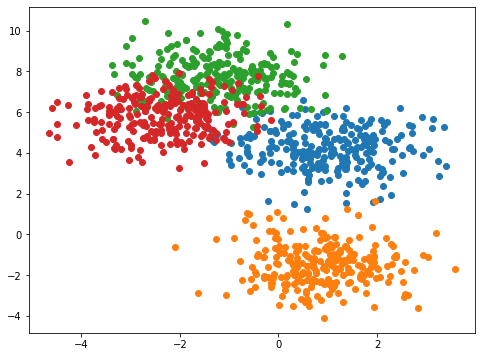

In [2]:
n_samples = 1000

X, y = make_blobs(n_samples=n_samples, centers=4, n_features=3,
                  random_state=0)
plt.figure(figsize=(8, 6))
for y_val in np.unique(y):
    plt.scatter(X[np.where(y == y_val)[0], 0], X[np.where(y == y_val)[0], 1])
plt.show()

In [3]:
# Generating dataset:
weekdays_names = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN', 'none']
data = {'id': np.arange(0, n_samples, 1),
        'num_col1': X[:, 0]*5,
        'num_col2': X[:, 1]*np.random.randint(1, 50) + np.random.randint(1, 100),
        'num_col3': X[:, 2]*np.random.randint(1, 500) + np.random.randint(1, 100),
        'num_col4': np.random.random(n_samples),
        'num_col5': np.random.random(n_samples),
        'cat_col1': np.random.choice(['a', 'b', 'c', 'd', 'e'], n_samples),
        'cat_col2': np.random.choice(['a', 'b', 'c', 'd', 'e'], n_samples),
        'cat_col3': np.random.choice(['a', 'b', 'c', 'd', 'e'], n_samples),
        'bool_col': np.random.choice([0, 1], n_samples),
        'bool_col_nan': np.random.choice([-1, 0, 1], n_samples),
        'class': y}

data = pd.DataFrame(data)
data

,id,num_col1,num_col2,num_col3,num_col4,num_col5,cat_col1,cat_col2,cat_col3,bool_col,bool_col_nan,class
0,0,-8.243023,304.978032,1496.222742,0.830106,0.574089,d,a,c,0,0,2
1,1,-3.196467,299.736534,1363.365704,0.214314,0.139046,b,b,e,0,0,2
2,2,-15.253717,227.574008,19.364800,0.973580,0.233883,b,c,e,1,0,3
3,3,-7.962813,339.103445,108.675660,0.437718,0.125176,b,a,a,1,-1,3
4,4,-5.002747,324.955950,1267.328021,0.171791,0.899825,e,a,a,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,-3.750063,222.173393,250.409041,0.681486,0.268573,d,a,c,1,1,0
996,996,-12.017042,295.407509,-64.067554,0.324164,0.137863,b,a,b,1,-1,3
997,997,-8.920852,388.714171,1341.011088,0.975521,0.699877,a,c,e,0,0,2
998,998,-9.172772,326.251894,86.928767,0.735923,0.070272,d,c,d,0,1,3


In [4]:
data.dtypes

id                int32
num_col1        float64
num_col2        float64
num_col3        float64
num_col4        float64
num_col5        float64
cat_col1         object
cat_col2         object
cat_col3         object
bool_col          int32
bool_col_nan      int32
class             int32
dtype: object

# Data preparation:

In [5]:
TARGET_COL = 'class'
TARGET_NAMES = [0, 1, 2, 3]

In [6]:
X = data.drop(columns=[TARGET_COL])
y = data[TARGET_COL]

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
print('Train:', x_train.shape[0], 'samples', x_train.shape[1], 'columns')
print('Test:', x_test.shape[0], 'samples', x_test.shape[1], 'columns')

Train: 700 samples 11 columns
Test: 300 samples 11 columns


# Pre-processing Pipeline:

In [9]:
# Creating the transformation:
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [10]:
# Feature Encoding:
numeric_features = ['num_col1', 'num_col2', 'num_col3']
categorical_features  = ['cat_col1', 'cat_col2', 'cat_col3']
passthrough_features = ['num_col5']
all_features_ = (numeric_features + categorical_features
                 + passthrough_features)

features_encoder = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                                   ('cat', categorical_transformer, categorical_features),
                                                   ('passthrough', 'passthrough', passthrough_features)],
                                     remainder='drop')

In [11]:
# Feature Construction:
features_creator = PolynomialFeatures(2, include_bias=False)

In [12]:
# Feature Selection:
clf_select = LinearSVC(C=0.01, penalty="l1", dual=False)
features_selector = SelectFromModel(clf_select)

In [13]:
preprocessor = Pipeline([('feature_encoding', features_encoder),
                         ('feature_creation', features_creator),
                         ('feature_selection', features_selector),
                        ])

In [14]:
# Columns dropped by preprocessor:
columns_to_drop = data.columns[~np.isin(data.columns, all_features_)]
columns_to_drop

Index(['id', 'num_col4', 'bool_col', 'bool_col_nan', 'class'], dtype='object')

In [15]:
x_train_transf = preprocessor.fit_transform(x_train, y_train)
pd.DataFrame(x_train_transf)

,0,1,2,3
0,0.941796,0.185873,0.376664,0.141875
1,0.875312,0.187002,0.395682,0.156564
2,0.847588,0.586090,0.354008,0.125322
3,0.440458,0.944167,0.854743,0.730586
4,0.651551,0.527412,0.298542,0.089127
...,...,...,...,...
695,0.563601,0.107301,0.418975,0.175540
696,0.695781,0.208513,0.389604,0.151791
697,0.864810,0.514341,0.273436,0.074767
698,0.616381,0.857622,0.806448,0.650358


In [16]:
x_encoded_test = pd.DataFrame(preprocessor.transform(x_test))
x_encoded_test

,0,1,2,3
0,0.323766,0.671981,0.170747,0.029155
1,0.492940,0.309169,0.242535,0.058823
2,0.646890,0.624794,0.084819,0.007194
3,0.692036,0.555997,0.230536,0.053147
4,0.553310,0.271483,0.290004,0.084103
...,...,...,...,...
295,0.635558,0.033486,0.319061,0.101800
296,0.489025,0.903532,0.820415,0.673080
297,0.220623,0.678677,0.252791,0.063903
298,0.541163,0.853789,0.747910,0.559370


# Training the model into the main pipeline:

In [17]:
# Creating the clf model:

# RandomForestClassifier:
parameters = {'n_estimators'      : range(1, 100),
              'criterion'         : ['gini', 'entropy'],
              'max_features'      : ['auto', 'sqrt', 'log2'],
              'class_weight'      : ['balanced', 'balanced_subsample', None],
              'min_samples_split' : range(1, 3),
              'min_samples_leaf'  : range(1, 3),
              'max_depth'    : range(1, 10)}

# clf = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1)
clf = RandomizedSearchCV(RandomForestClassifier(), parameters, n_iter=50, n_jobs=-1)

In [18]:
# Training the model and getting the results:
clf.fit(x_train_transf, y_train)
clf_results = pd.DataFrame(clf.cv_results_).dropna(subset=['mean_test_score'])
clf_results.head()

C:\Users\weldl\Miniconda3\envs\onnx\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
125 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\weldl\Miniconda3\envs\onnx\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\weldl\Miniconda3\envs\onnx\lib\site-packages\sklearn\ensemble\_forest.py", line 441, in fit
    trees = Parallel(
  File "C:\Users\weldl\Miniconda3\envs\onnx\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.018021,0.002088,0.002693,0.000988,4,2,1,log2,9,entropy,balanced_subsample,"{'n_estimators': 4, 'min_samples_split': 2, 'm...",0.978571,0.985714,0.971429,0.978571,0.964286,0.975714,0.007284,12
2,0.274668,0.041728,0.018399,0.001858,94,2,1,log2,1,entropy,balanced,"{'n_estimators': 94, 'min_samples_split': 2, '...",0.750000,0.742857,0.757143,0.757143,0.750000,0.751429,0.005345,25
3,0.040121,0.004610,0.003391,0.001017,11,2,2,log2,8,entropy,None,"{'n_estimators': 11, 'min_samples_split': 2, '...",0.971429,0.971429,0.978571,0.964286,0.971429,0.971429,0.004518,19
8,0.275177,0.044984,0.018218,0.004325,85,2,1,log2,3,entropy,balanced,"{'n_estimators': 85, 'min_samples_split': 2, '...",0.971429,0.978571,0.985714,0.978571,0.985714,0.980000,0.005345,2
9,0.410300,0.077899,0.022591,0.002956,99,2,1,auto,5,gini,balanced_subsample,"{'n_estimators': 99, 'min_samples_split': 2, '...",0.971429,0.978571,0.985714,0.978571,0.985714,0.980000,0.005345,2


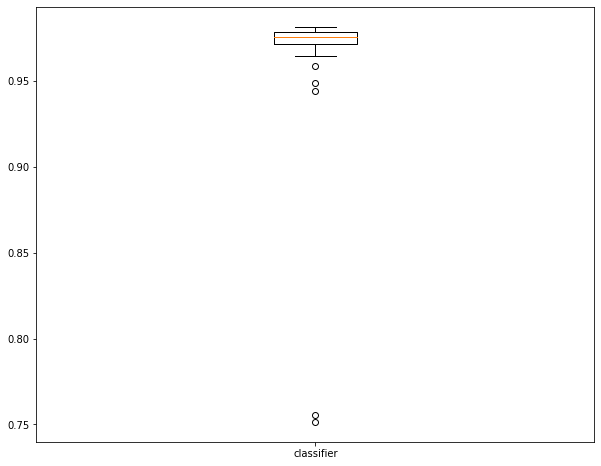

In [19]:
# Models performance:
plt.figure(figsize=(10, 8))
plt.boxplot([clf_results['mean_test_score']])
plt.xticks([1], ['classifier'])
plt.show()

In [20]:
clf.best_estimator_

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=5, max_features='sqrt', min_samples_leaf=2,
                       n_estimators=14)

In [21]:
model_full = Pipeline(steps=[('preprocessor', preprocessor),
                             ('estimator', clf.best_estimator_)])

In [22]:
y_pred = model_full.predict(x_test)
y_pred_probs = model_full.predict_proba(x_test)

In [23]:
results = pd.DataFrame(y_pred_probs, columns=clf.best_estimator_.classes_)
results['y_hat'] = y_pred
results.head(10)

,0,1,2,3,y_hat
0,0.002635,0.000000,0.0,0.997365,3
1,0.356703,0.555495,0.0,0.087801,1
2,0.860355,0.000000,0.0,0.139645,0
3,0.977715,0.013348,0.0,0.008937,0
4,0.042143,0.957857,0.0,0.000000,1
5,0.054434,0.000000,0.0,0.945566,3
6,0.206727,0.061088,0.0,0.732185,3
7,0.000000,1.000000,0.0,0.000000,1
8,0.015263,0.000000,0.0,0.984737,3
9,0.448158,0.004598,0.0,0.547244,3


# Model evaluation:

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        77
           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        60
           3       0.99      1.00      0.99        87

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



# Converting to ONNX format

In [25]:
onnx_conv = ONNXConverter(preprocessor, clf.best_estimator_)

In [26]:
onnx_conv.convert_initial_types(x_train, y_train, columns_to_drop, show_types=True)


Initial types preprocessing (7):
num_col1 FloatTensorType(shape=[None, 1])
num_col2 FloatTensorType(shape=[None, 1])
num_col3 FloatTensorType(shape=[None, 1])
num_col5 FloatTensorType(shape=[None, 1])
cat_col1 StringTensorType(shape=[None, 1])
cat_col2 StringTensorType(shape=[None, 1])
cat_col3 StringTensorType(shape=[None, 1])

Initial types estimator (1):
x_values FloatTensorType(shape=[None, 4])


In [27]:
prep_filename = './preprocessor_v0.onnx'
estimator_filename = './model_v0.onnx'

onnx_conv.dump_models(prep_filename=prep_filename,estimator_filename=estimator_filename)

C:\Users\weldl\Miniconda3\envs\onnx\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)


./preprocessor_v0.onnx saved successfully.
./model_v0.onnx saved successfully.


# Loading the ONNX files and performing predictions:

In [28]:
onnx_pred = ONNXPredictorCLF(prep_filename, estimator_filename)
onnx_pred.run_predictions(x_test)

array([3, 1, 0, 0, 1, 3, 3, 1, 3, 3, 3, 3, 3, 2, 3, 0, 2, 1, 3, 3, 0, 2,
       1, 0, 1, 3, 2, 3, 0, 2, 0, 0, 3, 0, 1, 3, 3, 0, 1, 3, 1, 1, 3, 0,
       2, 1, 3, 0, 1, 0, 0, 2, 1, 1, 2, 3, 2, 1, 3, 3, 3, 1, 1, 0, 3, 3,
       3, 1, 2, 0, 0, 0, 3, 0, 0, 0, 0, 3, 1, 0, 3, 1, 3, 0, 1, 2, 3, 3,
       3, 3, 2, 1, 3, 0, 1, 1, 3, 3, 0, 1, 0, 2, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 2, 2, 3, 2, 0, 0, 0, 1, 3, 1, 1, 2, 0, 3, 2, 2, 3, 0, 2, 2, 0,
       3, 0, 1, 3, 3, 1, 3, 2, 0, 3, 3, 2, 1, 2, 2, 3, 0, 3, 2, 2, 2, 0,
       2, 3, 0, 0, 1, 0, 0, 1, 1, 1, 0, 3, 1, 3, 2, 1, 3, 2, 0, 3, 3, 3,
       1, 1, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3, 2, 1, 2, 3, 2, 1, 2, 0, 3, 0,
       0, 1, 2, 1, 1, 1, 3, 1, 3, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 3, 2, 3,
       1, 0, 2, 3, 1, 3, 0, 3, 1, 3, 3, 3, 2, 0, 2, 1, 1, 2, 0, 1, 3, 2,
       0, 2, 0, 0, 3, 3, 0, 2, 0, 3, 0, 3, 0, 3, 0, 0, 2, 0, 3, 2, 0, 0,
       2, 0, 3, 1, 1, 2, 2, 2, 1, 0, 2, 2, 3, 1, 2, 1, 0, 1, 1, 1, 3, 3,
       1, 2, 3, 3, 2, 3, 2, 1, 1, 1, 2, 3, 2, 1], d

In [29]:
results_onx = pd.DataFrame(onnx_pred.output_probability)
results_onx['y_hat'] = onnx_pred.output_label
results_onx.head(10)

,0,1,2,3,y_hat
0,0.002635,0.000000,0.0,0.997365,3
1,0.356703,0.555495,0.0,0.087801,1
2,0.860355,0.000000,0.0,0.139645,0
3,0.977715,0.013348,0.0,0.008937,0
4,0.042143,0.957857,0.0,0.000000,1
5,0.054434,0.000000,0.0,0.945566,3
6,0.206727,0.061088,0.0,0.732185,3
7,0.000000,1.000000,0.0,0.000000,1
8,0.015263,0.000000,0.0,0.984737,3
9,0.448158,0.004598,0.0,0.547244,3


In [30]:
print(sum(results['y_hat'] == results_onx['y_hat']), 'equal results')
print(sum(results['y_hat'] != results_onx['y_hat']), 'different results')

300 equal results
0 different results


In [31]:
prob_diffs = results.loc[:, TARGET_NAMES] - results_onx.loc[:, TARGET_NAMES]
prob_diffs

,0,1,2,3
0,-1.662166e-11,0.000000e+00,0.0,-2.210229e-08
1,5.147891e-09,-1.362349e-08,0.0,1.025019e-09
2,-6.055089e-08,0.000000e+00,0.0,-1.395492e-08
3,-8.643334e-09,3.227876e-10,0.0,-6.135710e-11
4,8.811711e-10,1.401999e-08,0.0,0.000000e+00
...,...,...,...,...
295,8.811711e-10,1.401999e-08,0.0,0.000000e+00
296,0.000000e+00,0.000000e+00,0.0,0.000000e+00
297,5.259111e-10,0.000000e+00,0.0,3.199379e-09
298,0.000000e+00,0.000000e+00,0.0,0.000000e+00


In [32]:
prob_diffs.abs().mean()

0    7.916957e-09
1    1.600089e-09
2    0.000000e+00
3    7.589348e-09
dtype: float64

In [33]:
prob_diffs.abs().max()

0    9.738203e-08
1    2.554485e-08
2    0.000000e+00
3    9.478301e-08
dtype: float64

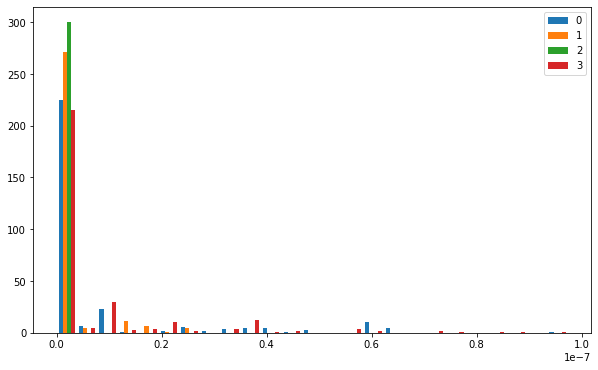

In [34]:
plt.figure(figsize=(10, 6))
plt.hist(prob_diffs.abs(), bins=25, label=prob_diffs.columns)
plt.legend()
plt.show()

In [35]:
# Deleting all files created:
os.remove(onnx_pred.prep_filename)
os.remove(onnx_pred.estimator_filename)